In [12]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip3 install numpy pandas matplotlib seaborn scikit-learn scipy tqdm
!pip3 install yfinance
!pip3 install cvxpy ecos scs osqp
!pip3 install python-dateutil


Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.24.1-cp313-cp313-macosx_12_0_arm64.whl.metadata (5.9 kB)
  Using cached https://download.pytorch.org/whl/cpu/torchaudio-2.9.1-cp313-cp313-macosx_12_0_arm64.whl.metadata (6.9 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 8.6 MB/s  0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 MB 27.6 MB/s  0:00:02m0:00:0100:01
Using cached https://download.pytorch.org/whl/cpu/torchvision-0.24.1-cp313-cp313-macosx_12_0_arm64.whl (1.9 MB)
Using cached https://download.pytorch.org/whl/cpu/torchaudio-2.9.1-cp313-cp313-macosx_12_0_arm64.whl (808 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 25.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [42]:

import os, shutil
from pathlib import Path
import pickle, math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cvxpy as cp
import yfinance as yf
from tqdm import tqdm
import scipy.stats as stats

Path('data').mkdir(exist_ok=True)
Path('models').mkdir(exist_ok=True)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device('cpu')
print("device:", device)

TICKERS = ['MSFT','NVDA','AAPL','AMZN','GOOGL','META','TSLA','JPM','UNH','PG','V','MA']
YEARS_OF_DATA = 7
SEQ_LEN = 20
H = 21                       
ALPHA = 0.95                 
GAMMA = 1.0                  
M_SYN = 2000                 
W_MAX = 0.25                 
L2_LAMBDA = 1e-3             
TRAIN_VAL_SPLIT = 0.8        
WALKFWD_TRAIN_DAYS = 252*2   
WALKFWD_STEP = H             
CLAMP_RET = 0.20             


device: cpu


In [43]:

tickers = TICKERS.copy()
end_date = datetime.date.today()
start_date = (end_date - datetime.timedelta(days=365*YEARS_OF_DATA)).isoformat()
end_date = end_date.isoformat()

print("Downloading price data for", tickers)
raw = yf.download(tickers, start=start_date, end=end_date, progress=False, group_by='ticker', threads=True)


if isinstance(raw.columns, pd.MultiIndex):
    try:
        adj = raw.xs('Adj Close', axis=1, level=1)
    except Exception:
        try:
            adj = raw.xs('Close', axis=1, level=1)
        except Exception:
            raw_flat = raw.copy()
            raw_flat.columns = ['.'.join(map(str,c)) for c in raw_flat.columns]
            possible = [c for c in raw_flat.columns if any(t in c for t in tickers)]
            adj = raw_flat[possible]
else:
    adj = raw.copy()


clean_cols = []
for c in adj.columns:
    if isinstance(c, str) and ('.' in c or ' ' in c):
        match = next((t for t in tickers if t in c), c)
        clean_cols.append(match)
    else:
        clean_cols.append(c)
adj.columns = clean_cols


adj = adj.ffill().bfill().dropna(how='all')
if adj.shape[1] == 0:
    raise RuntimeError("Adj close extraction failed - raw.columns: " + str(raw.columns))
adj.to_csv('data/adjclose.csv')


returns_df = adj.pct_change().dropna(how='all')
returns_df = returns_df[tickers]  
returns_df.to_csv('data/returns.csv')
print("Saved data/adjclose.csv and data/returns.csv shapes:", adj.shape, returns_df.shape)


/var/folders/5d/cxg576h92j906wv9p0xyjc3c0000gn/T/ipykernel_8011/3566955343.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, start=start_date, end=end_date, progress=False, group_by='ticker', threads=True)


Saved data/adjclose.csv and data/returns.csv shapes: (1757, 12) (1756, 12)


In [44]:

returns = pd.read_csv('data/returns.csv', index_col=0, parse_dates=True)
returns = returns[TICKERS]

q_low = 0.001
q_high = 0.999
for col in returns.columns:
    lo = returns[col].quantile(q_low)
    hi = returns[col].quantile(q_high)
    returns[col] = returns[col].clip(lower=lo, upper=hi)

mu = returns.mean(axis=0).values.astype(np.float32)
sigma = returns.std(axis=0).values.astype(np.float32)
sigma[sigma == 0] = 1e-8

returns_std = (returns - mu) / sigma
returns_std.to_csv('data/returns_std.csv')

meta = {'tickers': TICKERS, 'seq_len': SEQ_LEN, 'mu': mu, 'sigma': sigma}
with open('models/meta.pkl','wb') as f:
    pickle.dump(meta, f)


n = len(returns_std)
split_idx = int(n * TRAIN_VAL_SPLIT)
train_std = returns_std.iloc[:split_idx].copy()
val_std = returns_std.iloc[split_idx:].copy()


train_std.to_csv('data/train_returns_std.csv')
val_std.to_csv('data/val_returns_std.csv')
print("Preprocessing done. Train len:", len(train_std), "Val len:", len(val_std))


Preprocessing done. Train len: 1404 Val len: 352


In [45]:
class ReturnsDataset(Dataset):
    def __init__(self, returns_df, seq_len=SEQ_LEN):
        arr = returns_df.values.astype(np.float32)
        self.seq_len = seq_len
        self.samples = []
        for i in range(seq_len, len(arr)):
            x = arr[i-seq_len:i]    
            y = arr[i]             
            self.samples.append((x, y))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]

def make_dataloaders_from_df(df_std, seq_len=SEQ_LEN, batch_size=128, val_frac=0.0):
    ds = ReturnsDataset(df_std, seq_len=seq_len)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=False)
    return dl

class MultiLSTM(nn.Module):
    def __init__(self, n_features, hidden_size=128, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, n_features)
    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)


ep 1/80 train_loss=1.017417e+00 val_loss=9.171618e-01 lr=1.000e-03
ep 2/80 train_loss=1.013120e+00 val_loss=9.156082e-01 lr=1.000e-03
ep 3/80 train_loss=1.008594e+00 val_loss=9.119279e-01 lr=1.000e-03
ep 4/80 train_loss=1.003533e+00 val_loss=9.093343e-01 lr=1.000e-03
ep 5/80 train_loss=9.932833e-01 val_loss=9.067213e-01 lr=1.000e-03
ep 6/80 train_loss=9.803676e-01 val_loss=9.095037e-01 lr=1.000e-03
ep 7/80 train_loss=9.679738e-01 val_loss=9.042161e-01 lr=1.000e-03
ep 8/80 train_loss=9.356815e-01 val_loss=9.067891e-01 lr=1.000e-03
ep 9/80 train_loss=9.135071e-01 val_loss=9.191967e-01 lr=1.000e-03
ep 10/80 train_loss=9.058714e-01 val_loss=9.137105e-01 lr=1.000e-03
ep 11/80 train_loss=8.869691e-01 val_loss=9.182192e-01 lr=5.000e-04
ep 12/80 train_loss=8.646163e-01 val_loss=9.276790e-01 lr=5.000e-04
ep 13/80 train_loss=8.538313e-01 val_loss=9.306486e-01 lr=5.000e-04
ep 14/80 train_loss=8.479449e-01 val_loss=9.345210e-01 lr=5.000e-04
ep 15/80 train_loss=8.362661e-01 val_loss=9.403688e-01 lr

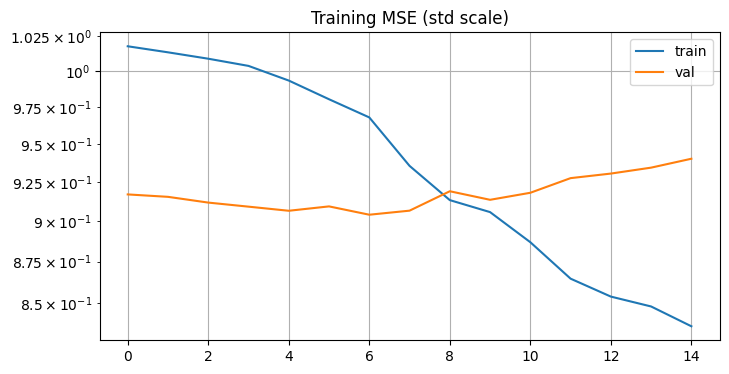

In [46]:
def train_on_trainset(train_std_df, val_std_df=None, seq_len=SEQ_LEN,
                      hidden_size=128, num_layers=2, lr=1e-3, epochs=60,
                      batch_size=128, weight_decay=1e-5, patience=8, weight_path='models/lstm_best.pth'):
    n_features = train_std_df.shape[1]
    model = MultiLSTM(n_features, hidden_size=hidden_size, num_layers=num_layers).to(device)
    dl_train = make_dataloaders_from_df(train_std_df, seq_len=seq_len, batch_size=batch_size)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3)
    criterion = nn.MSELoss()

    best_val = np.inf
    history = {'train_loss':[], 'val_loss':[]}
    epochs_no_improve = 0

    for ep in range(epochs):
        model.train()
        run = 0.0; cnt = 0
        for xb, yb in dl_train:
            xb = xb.to(device); yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            opt.zero_grad(); loss.backward(); opt.step()
            run += loss.item() * xb.size(0); cnt += xb.size(0)
        train_loss = run/cnt if cnt>0 else np.nan
        val_loss = np.nan
        if val_std_df is not None:
            model.eval()
            run = 0.0; cnt = 0
            arr = val_std_df.values.astype(np.float32)
            with torch.no_grad():
                for i in range(seq_len, len(arr)):
                    x = arr[i-seq_len:i]; y = arr[i]
                    x_t = torch.from_numpy(x).unsqueeze(0).to(device)
                    pred = model(x_t)
                    loss = criterion(pred, torch.from_numpy(y).unsqueeze(0).to(device))
                    run += float(loss.item()); cnt += 1
            val_loss = run/cnt if cnt>0 else np.nan
            scheduler.step(val_loss)
        history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
        old_lr = opt.param_groups[0]['lr']
        print(f"ep {ep+1}/{epochs} train_loss={train_loss:.6e} val_loss={val_loss:.6e} lr={old_lr:.3e}")
        score = val_loss if not math.isnan(val_loss) else train_loss
        if score < best_val - 1e-12:
            best_val = score
            torch.save(model.state_dict(), weight_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping.")
            break

    model.load_state_dict(torch.load(weight_path, map_location=device))
    return model, history


train_std_df = pd.read_csv('data/train_returns_std.csv', index_col=0, parse_dates=True)
val_std_df = pd.read_csv('data/val_returns_std.csv', index_col=0, parse_dates=True)
model, history = train_on_trainset(train_std_df, val_std_df, seq_len=SEQ_LEN,
                                   hidden_size=256, num_layers=2, lr=1e-3, epochs=80,
                                   batch_size=128, weight_decay=1e-5, patience=8)

plt.figure(figsize=(8,4)); plt.semilogy(history['train_loss'], label='train'); plt.semilogy(history['val_loss'], label='val')
plt.legend(); plt.grid(True); plt.title('Training MSE (std scale)'); plt.show()


In [47]:
with open('models/meta.pkl','rb') as f:
    meta = pickle.load(f)
mu = np.asarray(meta['mu'], dtype=np.float32)
sigma = np.asarray(meta['sigma'], dtype=np.float32)
tickers = meta['tickers']

val_df = pd.read_csv('data/returns.csv', index_col=0, parse_dates=True).iloc[int(len(returns)*(TRAIN_VAL_SPLIT)):]

preds = []
ys = []
arr = val_df.values.astype(np.float32)
for i in range(SEQ_LEN, len(arr)):
    x_orig = arr[i-SEQ_LEN:i]                     
    x_std = ((x_orig - mu) / sigma).astype(np.float32)
    x_t = torch.from_numpy(x_std).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_std = model(x_t).cpu().numpy().astype(np.float32).reshape(-1)
    pred_orig = (pred_std * sigma) + mu
    true_orig = arr[i]
    preds.append(pred_orig)
    ys.append(true_orig)

preds = np.vstack(preds).astype(np.float32)
ys = np.vstack(ys).astype(np.float32)
residuals_val = (ys - preds).astype(np.float32)   

np.save('models/residuals_val.npy', residuals_val)
sigma_res_val = np.cov(residuals_val, rowvar=False).astype(np.float32)
np.save('models/sigma_res_val.npy', sigma_res_val)
print("Computed validation residuals (shape):", residuals_val.shape, "sigma_res_val shape:", sigma_res_val.shape)

print("Validation preds mean (per asset):", preds.mean(axis=0))
print("Validation true mean (per asset):", ys.mean(axis=0))
print("Validation residuals std (per asset):", residuals_val.std(axis=0))


Computed validation residuals (shape): (332, 12) sigma_res_val shape: (12, 12)
Validation preds mean (per asset): [ 7.1976852e-04  2.8257563e-03  1.6585258e-03 -9.1774840e-05
  6.4260658e-04  8.2864164e-04  2.3387398e-03  1.8081254e-03
  2.5564031e-04  8.5884851e-04  1.9796088e-04  7.6207006e-04]
Validation true mean (per asset): [ 0.00058612  0.00195321  0.00079757  0.00108955  0.00165093  0.00101203
  0.00255533  0.00148608 -0.00106026 -0.00020829  0.0008214   0.00078482]
Validation residuals std (per asset): [0.01451568 0.03236412 0.0187793  0.02136482 0.01932638 0.02221524
 0.04255058 0.01593812 0.02770131 0.01157801 0.01356747 0.01317186]


In [48]:
residuals_val = np.load('models/residuals_val.npy')  
sigma_res_val = np.load('models/sigma_res_val.npy')

def generate_paths_bootstrap(model, seed_window_orig, M=M_SYN, H=H, clamp=CLAMP_RET):
    seq_len, n = seed_window_orig.shape
    all_paths = np.zeros((M, H, n), dtype=np.float32)
    mu = np.asarray(meta['mu'], dtype=np.float32)
    sigma = np.asarray(meta['sigma'], dtype=np.float32)
    hist_std = ((seed_window_orig - mu) / sigma).astype(np.float32)
    for m in range(M):
        hist_std_local = hist_std.copy()
        path = []
        for h in range(H):
            x_t = torch.from_numpy(hist_std_local.astype(np.float32)).unsqueeze(0).to(device)
            with torch.no_grad():
                pred_std = model(x_t).cpu().numpy().astype(np.float32).reshape(-1)
            pred_orig = (pred_std * sigma) + mu   
            idx = np.random.randint(0, residuals_val.shape[0])
            eps = residuals_val[idx].astype(np.float32)
            r = pred_orig + eps
            r = np.clip(r, -clamp, clamp).astype(np.float32)
            path.append(r)
            r_std = ((r - mu) / sigma).astype(np.float32)
            hist_std_local = np.vstack([hist_std_local[1:], r_std])
        all_paths[m] = np.vstack(path)
    return all_paths

def cum_returns_from_paths(paths):
    return (np.prod(1 + paths, axis=1) - 1.0).astype(np.float32)


In [49]:
def solve_cvar_with_constraints(C, alpha=ALPHA, loss_limit=None, w_max=W_MAX, lam=L2_LAMBDA):
    M, n = C.shape
    w = cp.Variable(n, nonneg=True)
    t = cp.Variable()
    u = cp.Variable(M, nonneg=True)
    Rm = C @ w
    obj = cp.Maximize((1.0/M)*cp.sum(Rm) - lam*cp.sum_squares(w))
    constraints = [cp.sum(w) == 1, w <= w_max, u >= -Rm - t]
    cvar = t + (1.0/((1.0 - alpha) * M)) * cp.sum(u)
    if loss_limit is not None:
        constraints += [cvar <= loss_limit]
    prob = cp.Problem(obj, constraints)
    solvers = [cp.ECOS, cp.SCS, cp.OSQP]
    solved = False
    for s in solvers:
        try:
            prob.solve(solver=s, verbose=False)
            if w.value is not None:
                solved = True
                break
        except Exception:
            continue
    if not solved or w.value is None:
        raise RuntimeError("cvxpy failed or infeasible")
    w_opt = np.array(w.value).reshape(-1).astype(np.float32)
    cvar_val = float(cvar.value)
    exp_ret = float(np.sum(C @ w_opt) / M)
    return w_opt, cvar_val, exp_ret


In [50]:

returns_all = pd.read_csv('data/returns.csv', index_col=0, parse_dates=True)[TICKERS]
n = len(returns_all)
start_idx = int(252*1.5)
end_idx = n - H - 1
as_of_indices = list(range(start_idx, end_idx, WALKFWD_STEP))

print("Walk-forward rounds:", len(as_of_indices), "as_of range:", as_of_indices[:3], "...")
loss_grid = np.linspace(0.002, 0.12, 20)

results_by_loss = {float(l): {'pred_exp': [], 'pred_cvar': [], 'realized': [], 'weights': []} for l in loss_grid}

for as_of in tqdm(as_of_indices):
    seed_window = returns_all.values[as_of-SEQ_LEN+1: as_of+1]  
    paths = generate_paths_bootstrap(model, seed_window, M=M_SYN, H=H, clamp=CLAMP_RET)
    C = cum_returns_from_paths(paths)  
    forward_window = returns_all.values[as_of+1: as_of+1+H]
    real_asset_cum = np.prod(1 + forward_window, axis=0) - 1.0   

    for loss_limit in loss_grid:
        try:
            w_opt, pred_cvar, pred_exp = solve_cvar_with_constraints(C, alpha=ALPHA, loss_limit=float(loss_limit), w_max=W_MAX, lam=L2_LAMBDA)
        except Exception:
            results_by_loss[float(loss_limit)]['pred_exp'].append(np.nan)
            results_by_loss[float(loss_limit)]['pred_cvar'].append(np.nan)
            results_by_loss[float(loss_limit)]['realized'].append(np.nan)
            results_by_loss[float(loss_limit)]['weights'].append(None)
            continue
        realized_port = float(real_asset_cum @ w_opt)
        results_by_loss[float(loss_limit)]['pred_exp'].append(pred_exp)
        results_by_loss[float(loss_limit)]['pred_cvar'].append(pred_cvar)
        results_by_loss[float(loss_limit)]['realized'].append(realized_port)
        results_by_loss[float(loss_limit)]['weights'].append(w_opt)

print("Walk-forward complete.")


Walk-forward rounds: 65 as_of range: [378, 399, 420] ...


  0%|          | 0/65 [00:00<?, ?it/s]/Users/kumarshivam/Documents/ACADEMICS SEVENTH SEMESTER/CS787 GEN AI/project/.venv/lib/python3.13/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 65/65 [1:36:54<00:00, 89.46s/it] 

Walk-forward complete.


/var/folders/5d/cxg576h92j906wv9p0xyjc3c0000gn/T/ipykernel_8011/2440857971.py:16: RuntimeWarning: Mean of empty slice
  avg_pred_exp.append(np.nanmean(arr_pred_valid))
/var/folders/5d/cxg576h92j906wv9p0xyjc3c0000gn/T/ipykernel_8011/2440857971.py:17: RuntimeWarning: Mean of empty slice
  avg_pred_cvar.append(np.nanmean(arr_cvar_valid))
/var/folders/5d/cxg576h92j906wv9p0xyjc3c0000gn/T/ipykernel_8011/2440857971.py:18: RuntimeWarning: Mean of empty slice
  avg_realized.append(np.nanmean(arr_real_valid))


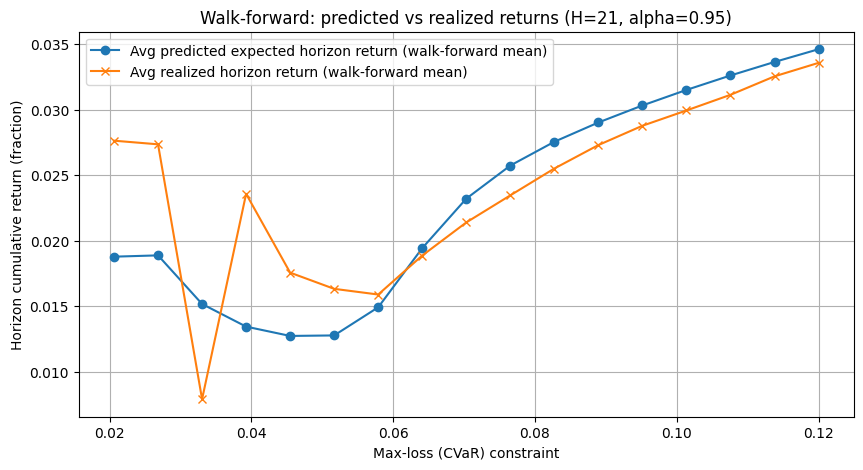

In [51]:
loss_grid = sorted(list(results_by_loss.keys()))
avg_pred_exp = []
avg_pred_cvar = []
avg_realized = []
exceed_rates = []
kupiec_stats = []

for l in loss_grid:
    arr_pred = np.array(results_by_loss[l]['pred_exp'], dtype=np.float32)
    arr_cvar = np.array(results_by_loss[l]['pred_cvar'], dtype=np.float32)
    arr_real = np.array(results_by_loss[l]['realized'], dtype=np.float32)
    mask = ~np.isnan(arr_real)
    arr_real_valid = arr_real[mask]
    arr_pred_valid = arr_pred[mask]
    arr_cvar_valid = arr_cvar[mask]
    avg_pred_exp.append(np.nanmean(arr_pred_valid))
    avg_pred_cvar.append(np.nanmean(arr_cvar_valid))
    avg_realized.append(np.nanmean(arr_real_valid))
    fails = np.sum(( -arr_real_valid ) > arr_cvar_valid)
    n = len(arr_real_valid)
    exceed = fails / n if n>0 else np.nan
    exceed_rates.append(exceed)
    p = 1.0 - ALPHA
    if n > 0:
        pi = fails / n
        eps = 1e-12
        term1 = (pi if pi>0 else eps)**fails * ((1-pi) if (1-pi)>0 else eps)**(n-fails)
        term0 = (p if p>0 else eps)**fails * ((1-p) if (1-p)>0 else eps)**(n-fails)
        LR = -2.0 * np.log(term0 / term1) if term1>0 and term0>0 else np.nan
        pval = stats.chi2.sf(LR, df=1) if not np.isnan(LR) else np.nan
    else:
        LR = np.nan; pval = np.nan
    kupiec_stats.append((LR, pval))

plt.figure(figsize=(10,5))
plt.plot(loss_grid, avg_pred_exp, marker='o', label='Avg predicted expected horizon return (walk-forward mean)')
plt.plot(loss_grid, avg_realized, marker='x', label='Avg realized horizon return (walk-forward mean)')
plt.xlabel('Max-loss (CVaR) constraint')
plt.ylabel('Horizon cumulative return (fraction)')
plt.title(f'Walk-forward: predicted vs realized returns (H={H}, alpha={ALPHA})')
plt.legend(); plt.grid(True); plt.show()
